## Implementasi Metode VADER-LSTM dalam Pengujian Pengaruh Sentimen Investor terhadap Prediksi Harga Saham

In [1]:
import math
import nltk
import unicodedata
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dt
from matplotlib.dates import DateFormatter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import models as md
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
import tensorflow as tf
tf.version.VERSION

'2.13.0'

In [2]:
company = "TSLA"

### Importing Tweet Data

In [3]:
all_tweets = pd.read_csv("stock_tweets.csv")
print(all_tweets.shape)
all_tweets

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [4]:
tweet_df = all_tweets[all_tweets['Stock Name'] == company]
tweet_df = tweet_df.drop(['Company Name', 'Stock Name'], axis=1)
tweet_df['Date'] = pd.to_datetime(tweet_df['Date']).dt.date
tweet_df

,Date,Tweet
0,2022-09-29,Mainstream media has done an amazing job at br...
1,2022-09-29,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...
37417,2021-09-30,Playing in the dirt and #chasingsunsets\n@tesl...
37418,2021-09-30,I agree with @freshjiva that $TSLA ‘s EV busin...
37419,2021-09-30,Hold. On. Tight. $TSLA
37420,2021-09-30,Get ready for a $TSLA _ _ _ _ _ _ Q3 delivery...


#### Pre-processing the tweets

In [5]:
processed_df = tweet_df.copy()
processed_df

,Date,Tweet
0,2022-09-29,Mainstream media has done an amazing job at br...
1,2022-09-29,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...
37417,2021-09-30,Playing in the dirt and #chasingsunsets\n@tesl...
37418,2021-09-30,I agree with @freshjiva that $TSLA ‘s EV busin...
37419,2021-09-30,Hold. On. Tight. $TSLA
37420,2021-09-30,Get ready for a $TSLA _ _ _ _ _ _ Q3 delivery...


In [6]:
def preprocess_tweet(tweet):
    '''
    Takes a tweet as an input and output the list of tokens.
    '''
    
    import emoji
    import re
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    
    # Initialization
    new_tweet = tweet
    
    ## Changes on string
    
    # Remove urls
    new_tweet = re.sub(r'https?://[^ ]+', '', new_tweet)
    
    # Remove usernames
    new_tweet = re.sub(r'@[^ ]+', '', new_tweet)
    
    # Remove hashtags
    new_tweet = re.sub(r'#', '', new_tweet)
    
    # Character normalization
    new_tweet = re.sub(r'([A-Za-z])\1{2,}', r'\1', new_tweet)
    
    # Emoji transformation
    new_tweet = emoji.demojize(new_tweet)
    
    # Punctuation and special characters
    new_tweet = re.sub(r' 0 ', 'zero', new_tweet)
    new_tweet = re.sub(r'[^A-Za-z ]', '', new_tweet)
    
    # Lower casing
    new_tweet = new_tweet.lower()
    
    
    ## Changes on tokens
    
    # Tokenization
    tokens = word_tokenize(new_tweet)
    
    porter = PorterStemmer()

    for token in tokens:
        # Stopwords removal
        if token in stopwords.words('english'):
            tokens.remove(token)
        # Stemming
        token = porter.stem(token)
    
    return ' '.join(tokens)
    # return tokens

In [ ]:
for indx, row in processed_df.T.items():
    try:
        processed_df.at[indx, 'Tweet'] = preprocess_tweet(processed_df.at[indx, 'Tweet'])
    except TypeError:
        break

In [ ]:
processed_df.to_csv('tweet_processed.csv', index=False)

#### Labeling the tweets with VADER

In [7]:
processed_df = pd.read_csv('tweet_processed.csv')
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Tweet'] = processed_df['Tweet'].astype(str)
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df

,Date,Tweet
0,2022-09-29,mainstream media done amazing job brainwashing...
1,2022-09-29,tesla delivery estimates at around k the analy...
2,2022-09-29,even i include unvested rsus of additional equ...
3,2022-09-29,hahaha are still trying stop tesla fsd bro get...
4,2022-09-29,stop trying kill kids sad deranged old man
...,...,...
37417,2021-09-30,playing the dirt chasingsunsets
37418,2021-09-30,agree tsla ev business alone worth gt sh wo fs...
37419,2021-09-30,hold tight tsla
37420,2021-09-30,get ready a tsla q delivery numberhave ur answ...


In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in processed_df.T.items():
    try:
        sentence_sentiment = sentiment_analyzer.polarity_scores(processed_df.loc[indx, 'Tweet'])
        processed_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        processed_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        processed_df.at[indx, 'Positive'] = sentence_sentiment['pos']
        processed_df.at[indx, 'Compound'] = sentence_sentiment['compound']
    except TypeError:
        print (processed_df.loc[indx, 'Tweet'])
        print (indx)
        break

In [ ]:
processed_df.to_csv('tweet_processed_labeled.csv', index=False)

In [8]:
processed_df = pd.read_csv('tweet_processed_labeled.csv')
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Date'] = processed_df['Date'].dt.date
processed_df

,Date,Tweet,Negative,Neutral,Positive,Compound
0,2022-09-29,mainstream media done amazing job brainwashing...,0.181,0.655,0.164,0.0772
1,2022-09-29,tesla delivery estimates at around k the analy...,0.000,1.000,0.000,0.0000
2,2022-09-29,even i include unvested rsus of additional equ...,0.000,0.916,0.084,0.2960
3,2022-09-29,hahaha are still trying stop tesla fsd bro get...,0.336,0.488,0.176,-0.7096
4,2022-09-29,stop trying kill kids sad deranged old man,0.667,0.333,0.000,-0.8750
...,...,...,...,...,...,...
37417,2021-09-30,playing the dirt chasingsunsets,0.387,0.323,0.290,-0.1531
37418,2021-09-30,agree tsla ev business alone worth gt sh wo fs...,0.105,0.614,0.282,0.7003
37419,2021-09-30,hold tight tsla,0.000,1.000,0.000,0.0000
37420,2021-09-30,get ready a tsla q delivery numberhave ur answ...,0.000,0.737,0.263,0.3612


In [9]:
labeled_tweets_df = processed_df.copy()

for indx, row in processed_df.T.items():
    if (processed_df.at[indx, 'Compound'] > 0.5):
        labeled_tweets_df.at[indx, 'Sentiment'] = 'Positive'
    elif (processed_df.at[indx, 'Compound'] < -0.5):
        labeled_tweets_df.at[indx, 'Sentiment'] = 'Negative'
    else:
        labeled_tweets_df.at[indx, 'Sentiment'] = 'Neutral'

In [10]:
labeled_tweets_df

,Date,Tweet,Negative,Neutral,Positive,Compound,Sentiment
0,2022-09-29,mainstream media done amazing job brainwashing...,0.181,0.655,0.164,0.0772,Neutral
1,2022-09-29,tesla delivery estimates at around k the analy...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,even i include unvested rsus of additional equ...,0.000,0.916,0.084,0.2960,Neutral
3,2022-09-29,hahaha are still trying stop tesla fsd bro get...,0.336,0.488,0.176,-0.7096,Negative
4,2022-09-29,stop trying kill kids sad deranged old man,0.667,0.333,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...
37417,2021-09-30,playing the dirt chasingsunsets,0.387,0.323,0.290,-0.1531,Neutral
37418,2021-09-30,agree tsla ev business alone worth gt sh wo fs...,0.105,0.614,0.282,0.7003,Positive
37419,2021-09-30,hold tight tsla,0.000,1.000,0.000,0.0000,Neutral
37420,2021-09-30,get ready a tsla q delivery numberhave ur answ...,0.000,0.737,0.263,0.3612,Neutral


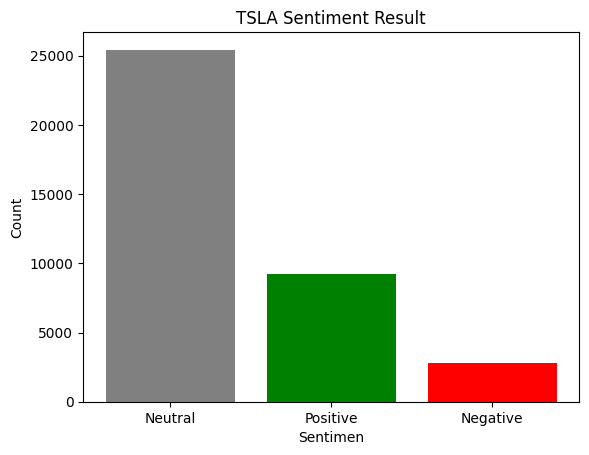

In [11]:
fig, ax = plt.subplots()
bar_colors = ['grey', 'green', 'red']
ax.bar(['Neutral', 'Positive', 'Negative'], labeled_tweets_df['Sentiment'].value_counts(), color=bar_colors)
ax.set(xlabel="Sentimen", ylabel="Count", title=f"{company} Sentiment Result")

plt.show()

In [12]:
daily_sentiments_df = labeled_tweets_df.groupby([labeled_tweets_df['Date']]).mean(numeric_only=True)
daily_sentiments_df

,Negative,Neutral,Positive,Compound
Date,,,,
2021-09-30,0.081300,0.739611,0.179067,0.241496
2021-10-01,0.051798,0.811106,0.137106,0.198523
2021-10-02,0.047888,0.768793,0.183353,0.264914
2021-10-03,0.061623,0.775557,0.162852,0.221228
2021-10-04,0.057303,0.821563,0.121118,0.100760
...,...,...,...,...
2022-09-25,0.079000,0.780000,0.141028,0.121844
2022-09-26,0.081292,0.765111,0.153556,0.130479
2022-09-27,0.059835,0.796282,0.143882,0.178928


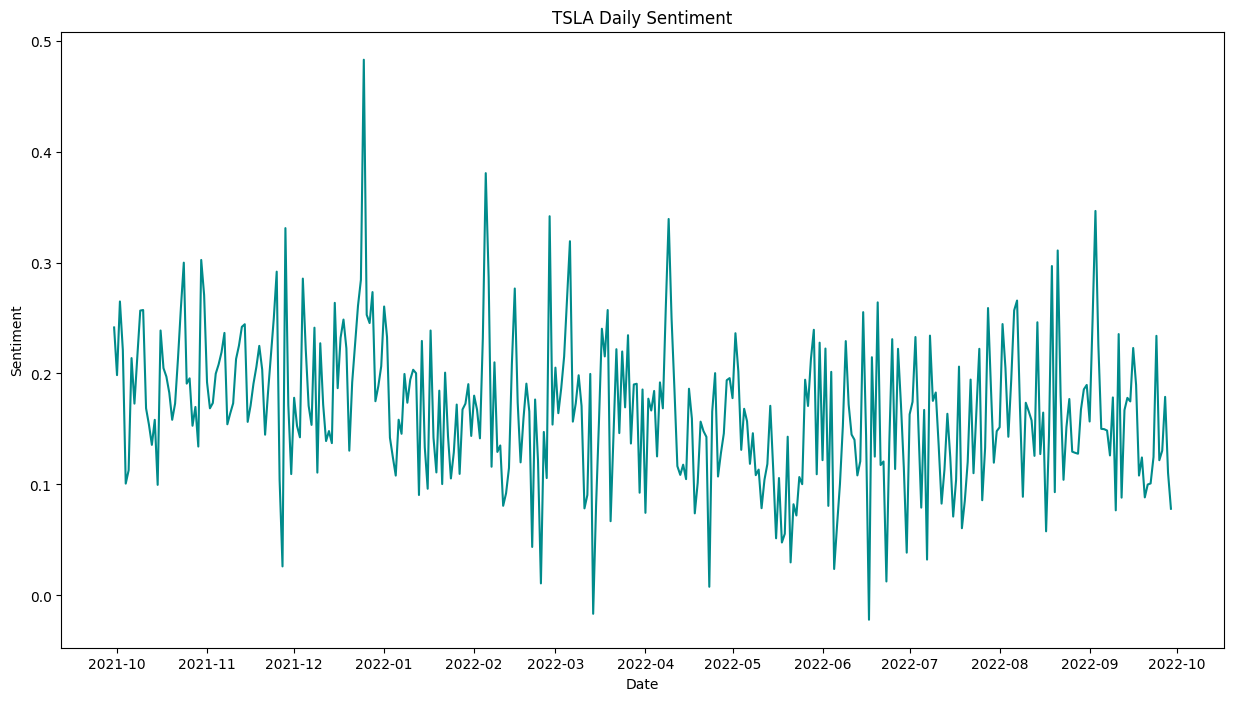

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(daily_sentiments_df['Compound'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Sentiment", title=f"{company} Daily Sentiment")
ax.xaxis.set_major_locator(dt.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

#### Grouping sentiments by day

In [14]:
daily_sentiments_df = processed_df.groupby([processed_df['Date']]).mean(numeric_only=True)
daily_sentiments_df

,Negative,Neutral,Positive,Compound
Date,,,,
2021-09-30,0.081300,0.739611,0.179067,0.241496
2021-10-01,0.051798,0.811106,0.137106,0.198523
2021-10-02,0.047888,0.768793,0.183353,0.264914
2021-10-03,0.061623,0.775557,0.162852,0.221228
2021-10-04,0.057303,0.821563,0.121118,0.100760
...,...,...,...,...
2022-09-25,0.079000,0.780000,0.141028,0.121844
2022-09-26,0.081292,0.765111,0.153556,0.130479
2022-09-27,0.059835,0.796282,0.143882,0.178928


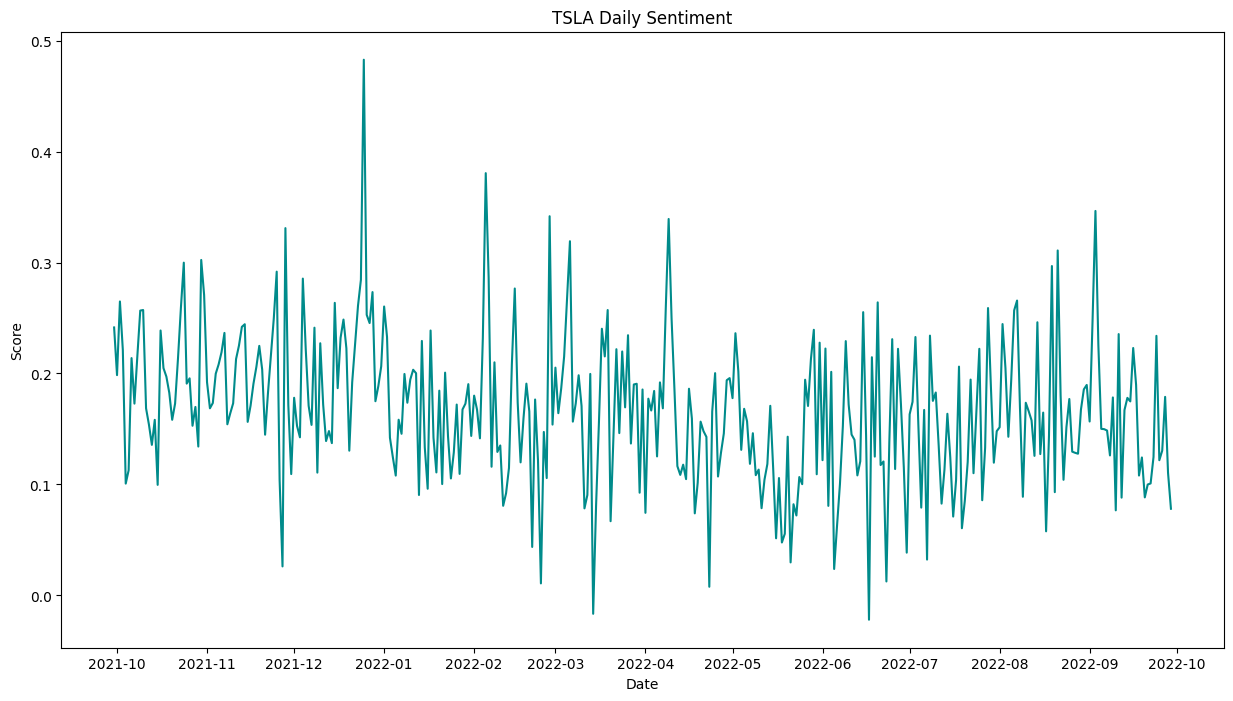

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(daily_sentiments_df['Compound'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Score", title=f"{company} Daily Sentiment")
ax.xaxis.set_major_locator(dt.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

### Importing Stock Data

In [17]:
all_stocks = pd.read_csv("stock_yfinance_data.csv")
all_stocks

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [18]:
stock_df = all_stocks[all_stocks['Stock Name'] == company]
stock_df = stock_df.drop('Stock Name', axis=1)
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df = stock_df.set_index("Date")
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400
...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200


In [19]:
stock_df.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400
...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200


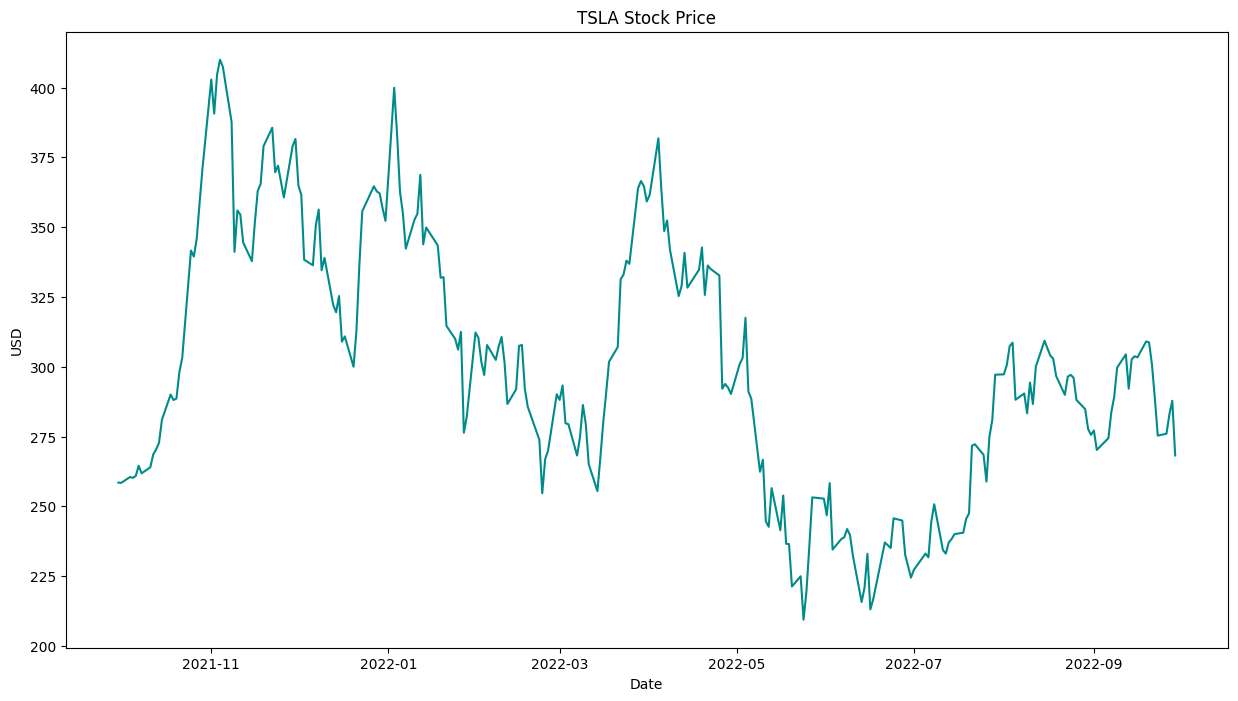

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(stock_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{company} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

In [21]:
dataset_df = stock_df.copy()
dataset_df = dataset_df.join(daily_sentiments_df, how="left", on="Date")
dataset_df

,Open,High,Low,Close,Adj Close,Volume,Negative,Neutral,Positive,Compound
Date,,,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.081300,0.739611,0.179067,0.241496
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.051798,0.811106,0.137106,0.198523
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.057303,0.821563,0.121118,0.100760
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.076352,0.796693,0.126989,0.112765
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.054769,0.771756,0.173500,0.213876
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,0.073233,0.792605,0.134128,0.124760
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,0.081292,0.765111,0.153556,0.130479
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,0.059835,0.796282,0.143882,0.178928


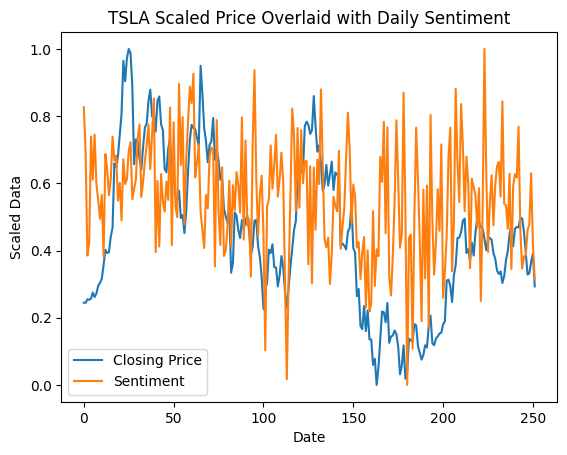

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset_df[['Close', 'Compound']].values)

fig, ax = plt.subplots()
ax.plot(scaled_data, label=["Closing Price", 'Sentiment'])
ax.set(xlabel="Date", ylabel="Scaled Data", title=f"{company} Scaled Price Overlaid with Daily Sentiment")
ax.legend()
# ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

### Functions

In [21]:
def SplitData(data, train_size, timestep):
    data_values = data.values
    training_data_len = math.ceil(len(data)* train_size)

    scaler = MinMaxScaler(feature_range=(0,1))
    if (len(data_values.shape) == 1):
        scaled_data = scaler.fit_transform(data_values.reshape(-1,1))
    else:
        scaled_data = scaler.fit_transform(data_values)
        scaled_index = scaler.fit_transform(data_values[:, 0:1].flatten().reshape(-1,1))

    train_data = scaled_data[0: training_data_len, :]
    test_data = scaled_data[training_data_len-timestep: , :]

    train_data_x = train_data[0: training_data_len, :]
    train_data_y = train_data[0: training_data_len, 0:1]

    x_train = []
    y_train = []

    for i in range(timestep, len(train_data_x)):
        x_train.append(train_data_x[i-timestep:i])
        y_train.append(train_data_y[i][0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    test_data = scaled_data[training_data_len-timestep: , : ]
    x_test = []
    if (len(data_values.shape) == 1):
        y_test = data_values[training_data_len:]
    else:
        y_test = data_values[training_data_len: , 0]

    for i in range(timestep, len(test_data)):
        x_test.append(test_data[i-timestep:i])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return x_train, y_train, x_test, y_test, scaler

In [22]:
def TrainModel(x_data, y_data, epoch):

    regressor = Sequential()
    regressor.add(LSTM(units=64, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=64, return_sequences=False))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = regressor.fit(x_data, y_data, batch_size=1, epochs=epoch, validation_split=0.2)

    return regressor, history

In [23]:
def PlotTrainingMetrics(history):
    history_data = history.history
    
    loss_values = history_data['loss']
    val_loss_values = history_data['val_loss']
    mae_values = history_data['mae']
    val_mae_values = history_data['val_mae']
    rmse_values = np.sqrt(history_data['loss'])
    val_rmse_values = np.sqrt(history_data['val_loss'])
    epochs = range(1, len(loss_values) + 1)

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 3, wspace=0)
    (ax1, ax2, ax3) = gs.subplots(sharey=True)
    fig.suptitle('Training and validation metrics')
    fig.supxlabel('epochs')

    ax1.plot(epochs, mae_values, color = 'blue', label='Training MAE')
    ax1.plot(epochs, val_mae_values, color='red', label='Validation MAE')
    ax1.set_title('MAE')
    ax1.set_xticks(epochs)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1.xaxis.grid(True, which='both', alpha=0.5)
    ax1.yaxis.grid(True, alpha=0.5)
    ax1.set_ylabel('value')
    ax1.legend()

    ax2.plot(epochs, loss_values, color = 'blue', label='Training loss')
    ax2.plot(epochs, val_loss_values, color='red', label='Validation loss')
    ax2.set_title('Loss (MSE)')
    ax2.set_xticks(epochs)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax2.xaxis.grid(True, which='both', alpha=0.5)
    ax2.yaxis.grid(True, alpha=0.5)
    ax2.legend()

    ax3.plot(epochs, rmse_values, color = 'blue', label='Training RMSE')
    ax3.plot(epochs, val_rmse_values, color='red', label='Validation RMSE')
    ax3.set_title('RMSE')
    ax3.set_xticks(epochs)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax3.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax3.xaxis.grid(True, which='both', alpha=0.5)
    ax3.yaxis.grid(True, alpha=0.5)
    ax3.legend()

In [24]:
def PlotPredictions(data, prediction):
    train_plot = data[:len(data)-len(prediction)]
    validation_plot = data[len(data)-len(prediction):].copy()
    validation_plot['Predictions'] = prediction

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Model and Predictions')
    ax.set_ylabel('Closing price (USD)')
    ax.set_xlabel('Date')
    ax.plot(train_plot)
    ax.plot(validation_plot[['Close', 'Predictions']])
    ax.xaxis.set_major_locator(dt.MonthLocator())
    ax.xaxis.set_minor_locator(dt.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(dt.DateFormatter('%b'))
    ax.grid(alpha=0.5, which='both')
    ax.legend(['Train', 'Validation', 'Predictions'])

### LSTM without Sentiment Score

In [44]:
close_prices = dataset_df['Close']

train_portion = 0.8
timestep = 60


x_train, y_train, x_test, y_test, scaler = SplitData(close_prices, train_portion, timestep)

In [30]:
singleModel, history_single = TrainModel(x_train, y_train, 10)

Epoch 1/10
113/113 [==============================] - 13s 57ms/step - loss: 0.0258 - mae: 0.1263 - mse: 0.0258 - val_loss: 0.0040 - val_mae: 0.0488 - val_mse: 0.0040
Epoch 2/10
113/113 [==============================] - 4s 38ms/step - loss: 0.0197 - mae: 0.1119 - mse: 0.0197 - val_loss: 0.0058 - val_mae: 0.0616 - val_mse: 0.0058
Epoch 3/10
113/113 [==============================] - 5s 40ms/step - loss: 0.0130 - mae: 0.0930 - mse: 0.0130 - val_loss: 0.0071 - val_mae: 0.0697 - val_mse: 0.0071
Epoch 4/10
113/113 [==============================] - 4s 39ms/step - loss: 0.0158 - mae: 0.1028 - mse: 0.0158 - val_loss: 0.0041 - val_mae: 0.0535 - val_mse: 0.0041
Epoch 5/10
113/113 [==============================] - 5s 42ms/step - loss: 0.0114 - mae: 0.0888 - mse: 0.0114 - val_loss: 0.0040 - val_mae: 0.0543 - val_mse: 0.0040
Epoch 6/10
113/113 [==============================] - 5s 42ms/step - loss: 0.0134 - mae: 0.0949 - mse: 0.0134 - val_loss: 0.0060 - val_mae: 0.0656 - val_mse: 0.0060
Epoch 7/1

In [34]:
singleModel.save('saved_model/single-features.h5')

c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
singleModel = md.load_model('saved_model/single-features.h5')

In [48]:
singleModel.get_weights()

[array([[ 0.12926285,  0.06264258,  0.16118509, -0.08997136,  0.17457218,
         -0.06163305,  0.0251762 ,  0.10587397, -0.08689006,  0.02169495,
         -0.00567362,  0.01067583,  0.10200822, -0.02178277, -0.02366581,
          0.05678234,  0.07840988, -0.08085577,  0.14381713,  0.15393996,
          0.1634726 , -0.0200363 ,  0.0794588 , -0.01499889,  0.00124033,
         -0.1323697 ,  0.0075926 ,  0.01231522,  0.169836  ,  0.01455838,
          0.14713718,  0.08836564,  0.06966859,  0.07578016,  0.0005162 ,
          0.1453175 ,  0.11842021,  0.00584261, -0.03497245, -0.07878373,
         -0.1300341 ,  0.12174848,  0.1701363 ,  0.06516213, -0.00947074,
         -0.04183519, -0.07963412,  0.12149849, -0.08989499, -0.06993008,
          0.07967431,  0.14481197, -0.13019846,  0.15232435, -0.07555447,
         -0.11419827,  0.13386615, -0.09408014, -0.11097383, -0.15689866,
          0.0939841 ,  0.02279827, -0.03255158,  0.12265618, -0.08891514,
          0.07951166,  0.05760974, -0.

In [46]:
singleModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
predictions_single = singleModel.predict(x_test)
predictions_single = scaler.inverse_transform(predictions_single)

mae = np.mean(np.abs(predictions_single - y_test))
mse = np.mean((predictions_single - y_test)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions_single)/y_test)) * 100
mae, mse, rmse, mape

2/2 [==============================] - 2s 22ms/step


(16.96082995605469, 437.38626997106076, 20.913781818959976, 5.962604849390294)

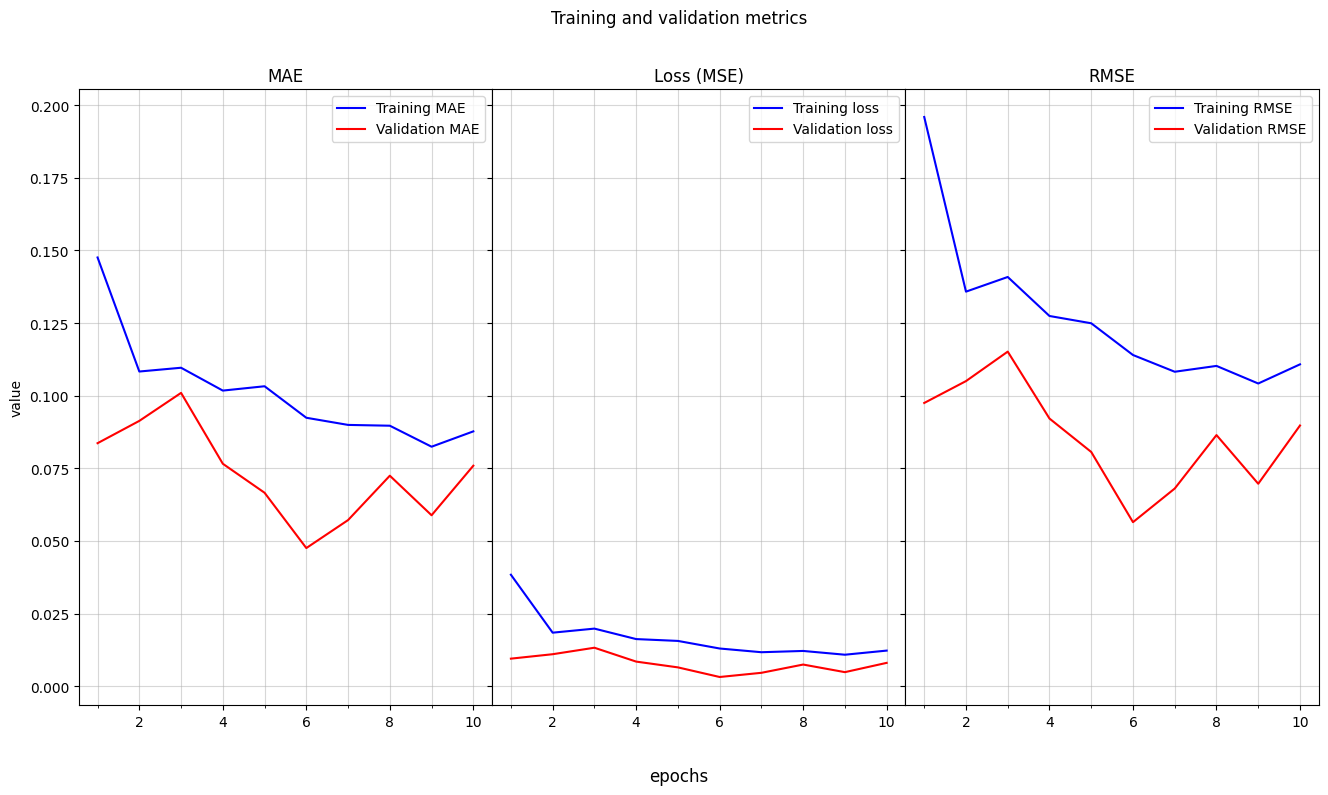

In [37]:
PlotTrainingMetrics(history_single)

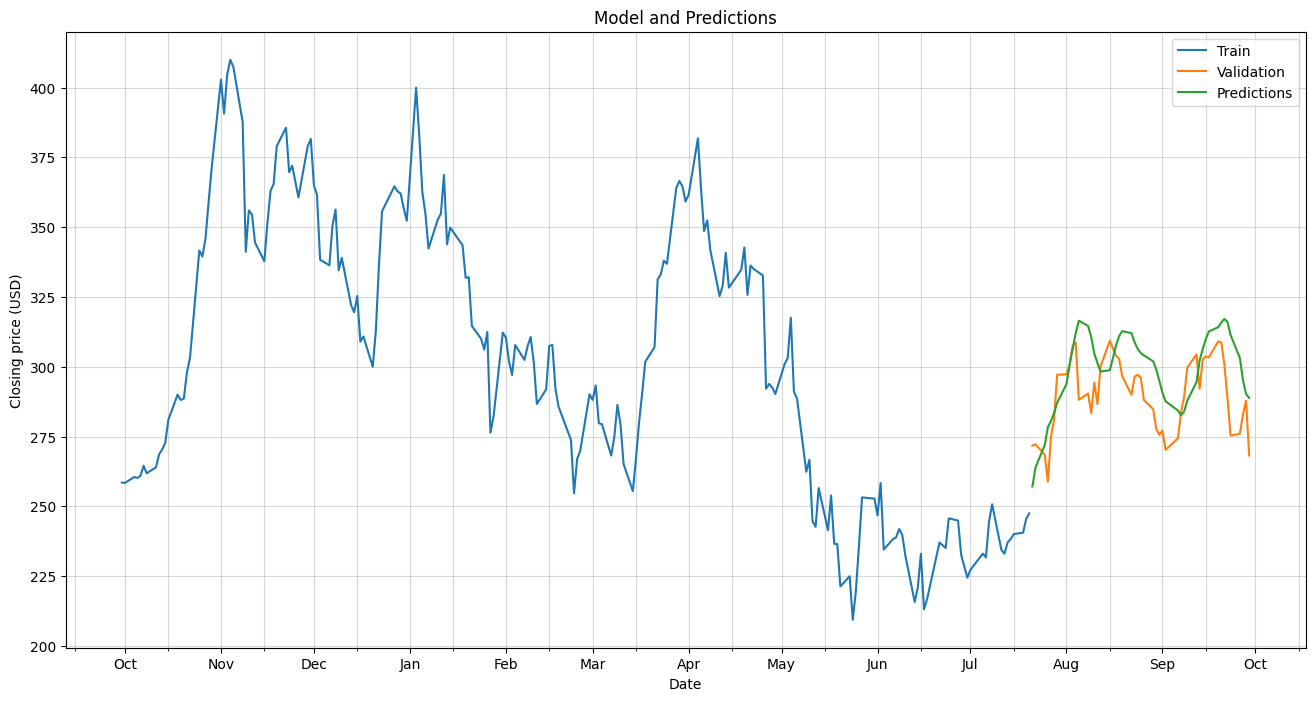

In [38]:
PlotPredictions(dataset_df.filter(['Close']), predictions_single)

### LSTM with User Sentiment Score

In [36]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

In [40]:
sentimentModel, history_sentiment = TrainModel(x_train, y_train, 10)

Epoch 1/10
113/113 [==============================] - 11s 45ms/step - loss: 0.0338 - mae: 0.1391 - mse: 0.0338 - val_loss: 0.0066 - val_mae: 0.0660 - val_mse: 0.0066
Epoch 2/10
113/113 [==============================] - 4s 31ms/step - loss: 0.0199 - mae: 0.1128 - mse: 0.0199 - val_loss: 0.0092 - val_mae: 0.0808 - val_mse: 0.0092
Epoch 3/10
113/113 [==============================] - 4s 32ms/step - loss: 0.0207 - mae: 0.1121 - mse: 0.0207 - val_loss: 0.0184 - val_mae: 0.1235 - val_mse: 0.0184
Epoch 4/10
113/113 [==============================] - 3s 31ms/step - loss: 0.0177 - mae: 0.1083 - mse: 0.0177 - val_loss: 0.0139 - val_mae: 0.1045 - val_mse: 0.0139
Epoch 5/10
113/113 [==============================] - 4s 32ms/step - loss: 0.0130 - mae: 0.0920 - mse: 0.0130 - val_loss: 0.0131 - val_mae: 0.1001 - val_mse: 0.0131
Epoch 6/10
113/113 [==============================] - 4s 31ms/step - loss: 0.0127 - mae: 0.0940 - mse: 0.0127 - val_loss: 0.0119 - val_mae: 0.0945 - val_mse: 0.0119
Epoch 7/1

In [41]:
sentimentModel.save('saved_model/multi-features.h5')

c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
sentimentModel = md.load_model('saved_model/multi-features.h5')

In [38]:
predictions = sentimentModel.predict(x_test)
predictions

2/2 [==============================] - 2s 21ms/step


array([[0.18894947],
       [0.22123945],
       [0.26564813],
       [0.3040497 ],
       [0.31140438],
       [0.32500887],
       [0.35269758],
       [0.38832492],
       [0.4180771 ],
       [0.45080987],
       [0.47916535],
       [0.49559683],
       [0.48801848],
       [0.47063598],
       [0.4384358 ],
       [0.4242016 ],
       [0.40985546],
       [0.4101562 ],
       [0.42273355],
       [0.43888414],
       [0.44200936],
       [0.44611686],
       [0.45416316],
       [0.4429929 ],
       [0.42704055],
       [0.41735172],
       [0.41259417],
       [0.3992478 ],
       [0.38553113],
       [0.36827788],
       [0.35058928],
       [0.33480576],
       [0.32366902],
       [0.3120412 ],
       [0.31346586],
       [0.32537046],
       [0.3555117 ],
       [0.38545057],
       [0.40607935],
       [0.42873517],
       [0.4474817 ],
       [0.46371964],
       [0.47164306],
       [0.47217557],
       [0.4632465 ],
       [0.44032758],
       [0.40498903],
       [0.370

In [39]:
predictions = scaler.inverse_transform(predictions)
predictions

array([[247.28677],
       [253.76361],
       [262.67126],
       [270.37396],
       [271.84918],
       [274.57803],
       [280.13193],
       [287.2782 ],
       [293.24597],
       [299.8116 ],
       [305.49924],
       [308.79514],
       [307.27505],
       [303.7884 ],
       [297.3296 ],
       [294.47443],
       [291.59683],
       [291.65717],
       [294.17996],
       [297.4195 ],
       [298.04636],
       [298.87027],
       [300.48422],
       [298.24365],
       [295.04388],
       [293.10046],
       [292.14618],
       [289.46912],
       [286.7178 ],
       [283.25708],
       [279.70905],
       [276.54312],
       [274.3093 ],
       [271.97693],
       [272.2627 ],
       [274.65054],
       [280.69638],
       [286.70163],
       [290.83942],
       [295.3838 ],
       [299.14404],
       [302.4011 ],
       [303.99042],
       [304.09723],
       [302.30618],
       [297.70905],
       [290.6207 ],
       [283.7802 ],
       [280.0489 ],
       [277.98083]],

In [40]:
mae = np.mean(np.abs(predictions - y_test))
mse = np.mean((predictions - y_test)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100
mae, mse, rmse, mape

(15.034818408203124,
 356.69338249142396,
 18.886327925020893,
 5.2093261004329925)

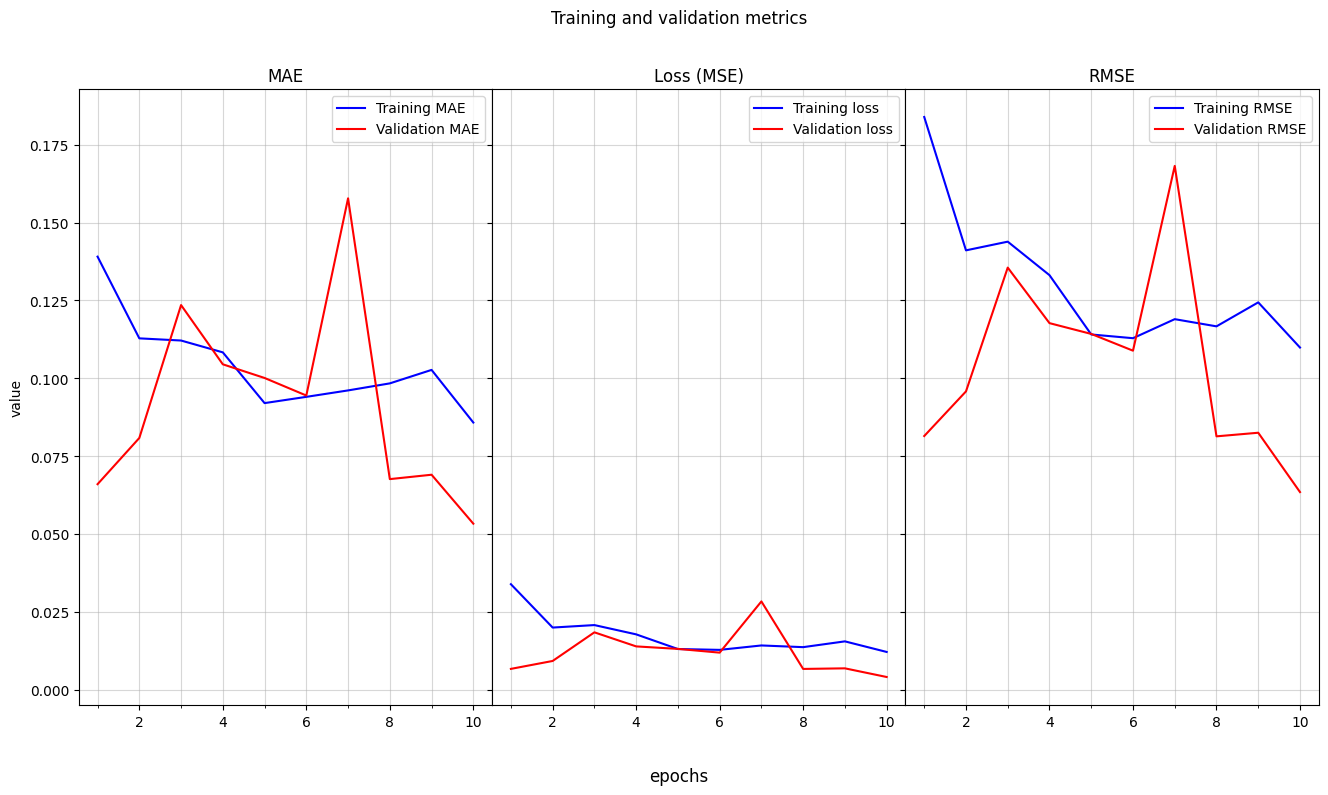

In [45]:
PlotTrainingMetrics(history_sentiment)

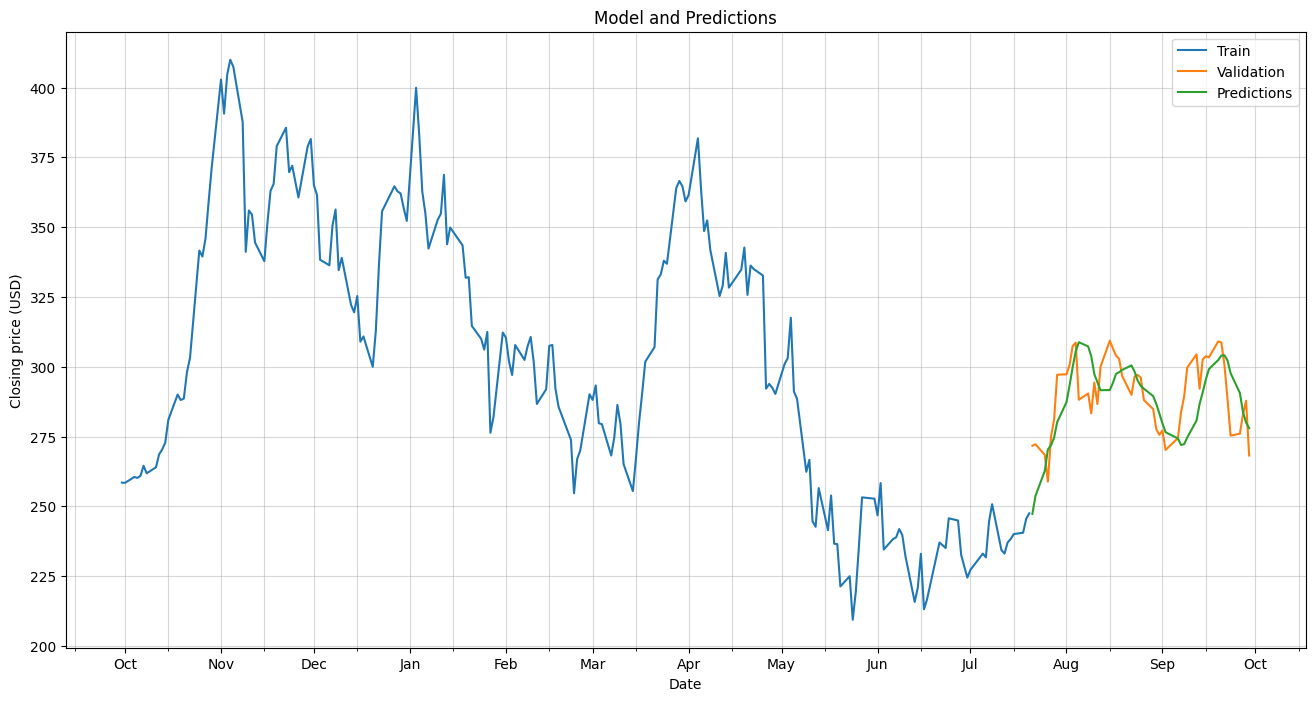

In [46]:
PlotPredictions(dataset_df.filter(['Close']), predictions)

## Fine Tuning with Grid Search

In [45]:
def TrainModelFineTune(x_data, y_data, epoch, neuron_units):

    regressor = Sequential()
    regressor.add(LSTM(units=neuron_units, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=neuron_units, return_sequences=False))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = regressor.fit(x_data, y_data, batch_size=1, epochs=epoch, validation_split=0.2)

    return regressor, history

### Fine Tune Epochs

In [ ]:
epochs = [5, 10, 20, 30, 40, 50]

epoch_finetune_history = []
epoch_finetune_test = []

In [ ]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [ ]:
for i in range(len(epochs)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(epochs[i]) + ' epochs')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error value')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for j in range(10):

        x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModelFineTune(x_train, y_train, epochs[i], 32)
        end_time = time.time()
        training_time = end_time - start_time

        predictions = sentimentModel.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        epoch_finetune_test.append([epochs[i], j, mae, mse, rmse, mape, training_time])

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        epoch_finetune_history.append([epochs[i], j, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])

        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('epoch_finetune_data/'+ str(epochs[i]) +'_epochs_diagnostic.png', facecolor=(1, 1, 1))

In [ ]:
epoch_test_finetuning = pd.DataFrame(epoch_finetune_test, columns=['#epoch', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
epoch_test_finetuning

In [ ]:
epoch_test_finetuning.to_csv('epoch_finetune_data/finetuning_test_data.csv', index=False)

In [92]:
epoch_test_finetuning = pd.read_csv('epoch_finetune_data/finetuning_test_data.csv')
epoch_test_finetuning

,#epoch,#try,MAE,MSE,RMSE,MAPE,train_time
0,5,0,16.452995,417.084625,20.422650,5.792440,27.497829
1,5,1,14.595786,337.351724,18.367137,5.085739,26.651451
2,5,2,21.534943,652.194895,25.538107,7.580885,26.448623
3,5,3,16.364322,411.876037,20.294729,5.764117,26.594965
4,5,4,16.382885,412.905221,20.320069,5.772575,30.561859
5,5,5,15.202103,357.268913,18.901558,5.198762,28.937516
6,5,6,16.426257,415.624994,20.386883,5.782871,27.776019
7,5,7,16.164125,398.580501,19.964481,5.518425,27.554009
8,5,8,17.525272,461.204532,21.475673,6.175580,27.610307
9,5,9,21.864256,677.010242,26.019420,7.695033,28.541749


In [132]:
epoch5 = epoch_test_finetuning[50:60]
epoch5.describe()

,#epoch,#try,MAE,MSE,RMSE,MAPE,train_time
count,10.0,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,50.0,4.50000,16.670705,426.711714,20.605761,5.836512,241.901400
std,0.0,3.02765,1.351747,63.002699,1.532730,0.494784,13.940568
min,50.0,0.00000,14.881234,343.470972,18.532970,5.169321,209.100802
25%,50.0,2.25000,15.516236,373.121193,19.314716,5.407902,237.469912
50%,50.0,4.50000,16.808647,431.450834,20.769464,5.893408,243.613860
75%,50.0,6.75000,17.791700,478.041037,21.862409,6.245964,251.783205
max,50.0,9.00000,18.470940,514.403258,22.680460,6.488050,257.872724


In [111]:
epoch_test_finetune_rmse = epoch_test_finetuning.pivot(index='#try', columns='#epoch', values='RMSE')
epoch_test_finetune_rmse

#epoch,5,10,20,30,40,50
#try,,,,,,
0,20.422650,21.925709,19.038973,20.986296,21.605176,22.021681
1,18.367137,20.048188,20.546504,19.931607,21.482426,19.169866
2,25.538107,19.387756,23.663993,19.450284,19.227749,22.346648
3,20.294729,18.514197,20.009697,20.767412,19.243231,18.633198
4,20.320069,21.950618,18.628566,20.048082,20.324311,22.680460
5,18.901558,19.118082,20.346684,18.930889,18.429901,21.052681
6,20.386883,21.312811,22.573524,20.893638,23.090616,18.532970
7,19.964481,19.075517,18.654510,24.572496,20.218544,19.749264
8,21.475673,18.472002,22.011396,18.993428,21.808539,21.384593


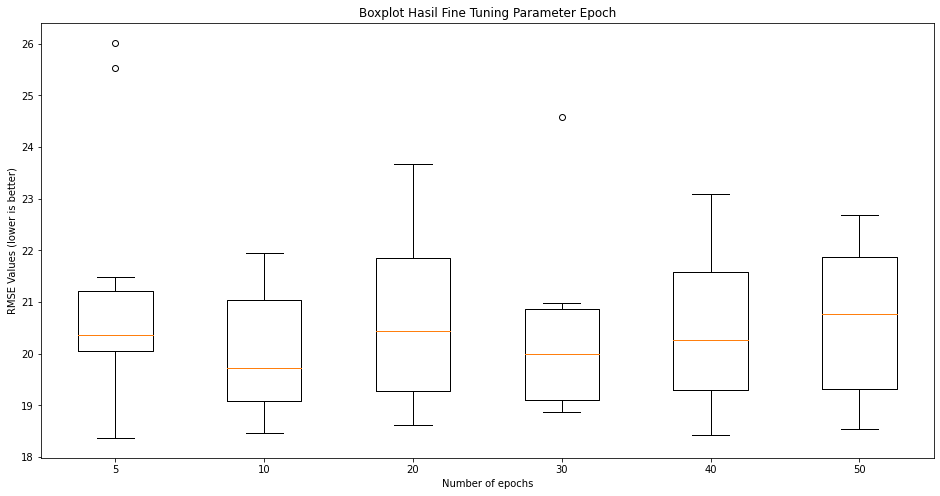

In [113]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(epoch_test_finetune_rmse)
ax.set_xticklabels(['5', '10', '20', '30', '40', '50'])
ax.set_title("Boxplot Hasil Fine Tuning Parameter Epoch")
ax.set_xlabel('Number of epochs')
ax.set_ylabel('RMSE Values (lower is better)')
plt.savefig('epoch_finetune_data/epoch_boxplot.png', facecolor=(1, 1, 1))

In [ ]:
epoch_history_finetuning = pd.DataFrame(epoch_finetune_history, columns=['#epoch', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
epoch_history_finetuning

In [ ]:
epoch_history_finetuning.to_csv('neuron_finetune_data/finetuning_history_data.csv', index=False)

### Neuron Number Finetuning

In [ ]:
epoch_final = 10
neurons = [16, 32, 64, 128]

neuron_finetune_history = []
neuron_finetune_test = []

In [ ]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [ ]:
for i in range(len(neurons)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(neurons[i]) + ' neurons')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error value')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for j in range(20):

        x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModelFineTune(x_train, y_train, epoch_final, neurons[i])
        end_time = time.time()
        training_time = end_time - start_time

        predictions = sentimentModel.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        neuron_finetune_test.append([neurons[i], j, mae, mse, rmse, mape, training_time])

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        neuron_finetune_history.append([neurons[i], j, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])

        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('neuron_finetune_data/'+ str(neurons[i]) +'_neuron_diagnostic.png', facecolor=(1, 1, 1))

In [ ]:
neuron_test_finetuning = pd.DataFrame(neuron_finetune_test, columns=['#neuron', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
neuron_test_finetuning

In [ ]:
neuron_test_finetuning.to_csv('neuron_finetune_data/finetuning_test_data.csv', index=False)

In [115]:
neuron_test_finetuning = pd.read_csv('neuron_finetune_data/finetuning_test_data.csv')
neuron_test_finetuning

,#neuron,#try,MAE,MSE,RMSE,MAPE,train_time
0,16,0,17.695826,475.483333,21.805580,6.206304,52.197898
1,16,1,16.093604,397.622572,19.940476,5.659776,51.745235
2,16,2,16.689922,425.245726,20.621487,5.872403,51.765287
3,16,3,20.150921,584.300803,24.172315,7.101445,52.100098
4,16,4,17.514474,459.169157,21.428233,6.154984,58.229036
...,...,...,...,...,...,...,...
75,128,15,20.690423,624.796080,24.995921,7.285243,60.039315
76,128,16,16.265432,417.062856,20.422117,5.561172,67.211189
77,128,17,16.210983,416.585762,20.410433,5.553936,77.891832
78,128,18,15.696495,383.569135,19.584921,5.480847,76.751030


In [144]:
y = neuron_test_finetuning[60:80]
y.drop(60).drop(67).drop(75).describe()

,#neuron,#try,MAE,MSE,RMSE,MAPE,train_time
count,17.0,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,128.0,9.882353,15.705242,385.437900,19.603528,5.438653,76.296766
std,0.0,5.786648,0.915534,43.996697,1.100363,0.307134,5.780271
min,128.0,1.000000,14.228578,312.896616,17.688884,4.930614,60.693647
25%,128.0,5.000000,14.966690,354.196907,18.820120,5.199601,74.740710
50%,128.0,10.000000,15.609602,381.266070,19.526036,5.446181,76.751030
75%,128.0,14.000000,16.210983,416.585762,20.410433,5.553936,79.217323
max,128.0,19.000000,18.190017,504.109842,22.452391,6.191079,87.135990


In [116]:
neuron_test_finetune_rmse = neuron_test_finetuning.pivot(index='#try', columns='#neuron', values='RMSE')
neuron_test_finetune_rmse

#neuron,16,32,64,128
#try,,,,
0,21.805580,24.282765,22.268389,23.462035
1,19.940476,23.774139,18.238622,18.820120
2,20.621487,18.472529,20.640312,18.477468
3,24.172315,20.482719,22.773900,22.452391
4,21.428233,18.395152,18.259001,19.314401
5,22.614635,18.612441,17.280112,18.404580
6,18.537159,18.511269,18.862729,19.526036
7,18.677301,18.234953,18.718866,24.379188
8,18.519584,21.864587,17.756366,20.474989


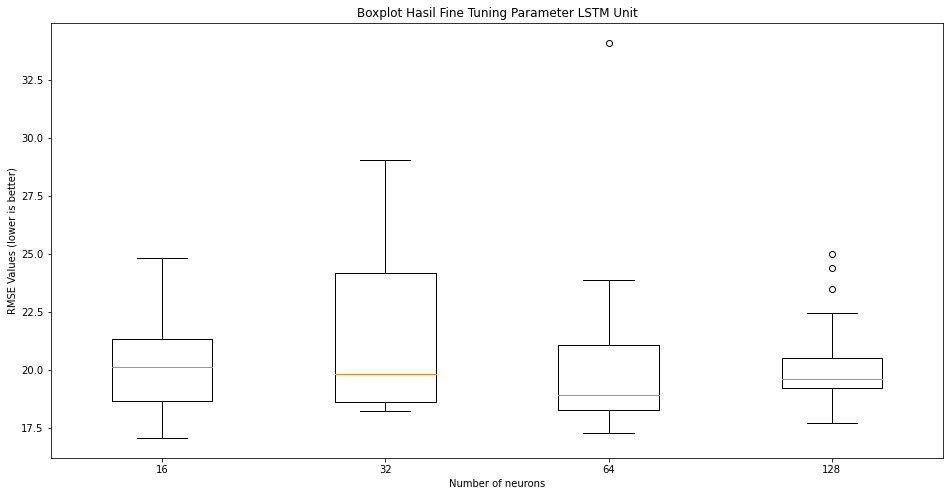

In [134]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(neuron_test_finetune_rmse)
ax.set_xticklabels(['16', '32', '64', '128'])
ax.set_title("Boxplot Hasil Fine Tuning Parameter LSTM Unit")
ax.set_xlabel('Number of neurons')
ax.set_ylabel('RMSE Values (lower is better)')
plt.savefig('neuron_finetune_data/neuron_boxplot.png', facecolor=(1, 1, 1))

In [ ]:
neuron_history_finetuning = pd.DataFrame(neuron_finetune_history, columns=['#neuron', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
neuron_history_finetuning

In [ ]:
neuron_history_finetuning.to_csv('neuron_finetune_data/finetuning_history_data.csv', index=False)

In [ ]:
neuron_history_finetuning = pd.read_csv('neuron_finetune_data/finetuning_history_data.csv')
neuron_history_finetuning

# COMPARE

In [47]:
model_mode = ['single', 'combined']

compare_finetune_history = []
compare_finetune_test = []

In [48]:
single_data = dataset_df['Close']
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

Epoch 1/10
113/113 [==============================] - 13s 64ms/step - loss: 0.0560 - mae: 0.1761 - val_loss: 0.0214 - val_mae: 0.1371
Epoch 2/10
113/113 [==============================] - 4s 34ms/step - loss: 0.0221 - mae: 0.1210 - val_loss: 0.0089 - val_mae: 0.0798
Epoch 3/10
113/113 [==============================] - 4s 35ms/step - loss: 0.0170 - mae: 0.1052 - val_loss: 0.0060 - val_mae: 0.0630
Epoch 4/10
113/113 [==============================] - 4s 37ms/step - loss: 0.0170 - mae: 0.1067 - val_loss: 0.0030 - val_mae: 0.0415
Epoch 5/10
113/113 [==============================] - 4s 34ms/step - loss: 0.0174 - mae: 0.1049 - val_loss: 0.0075 - val_mae: 0.0723
Epoch 6/10
113/113 [==============================] - 4s 39ms/step - loss: 0.0131 - mae: 0.0949 - val_loss: 0.0080 - val_mae: 0.0744
Epoch 7/10
113/113 [==============================] - 4s 39ms/step - loss: 0.0141 - mae: 0.0978 - val_loss: 0.0104 - val_mae: 0.0869
Epoch 8/10
113/113 [==============================] - 4s 33ms/step -

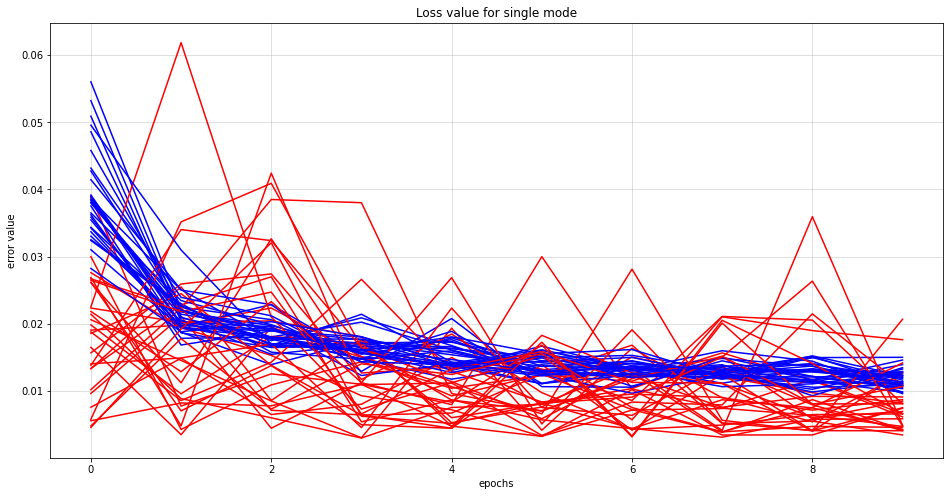

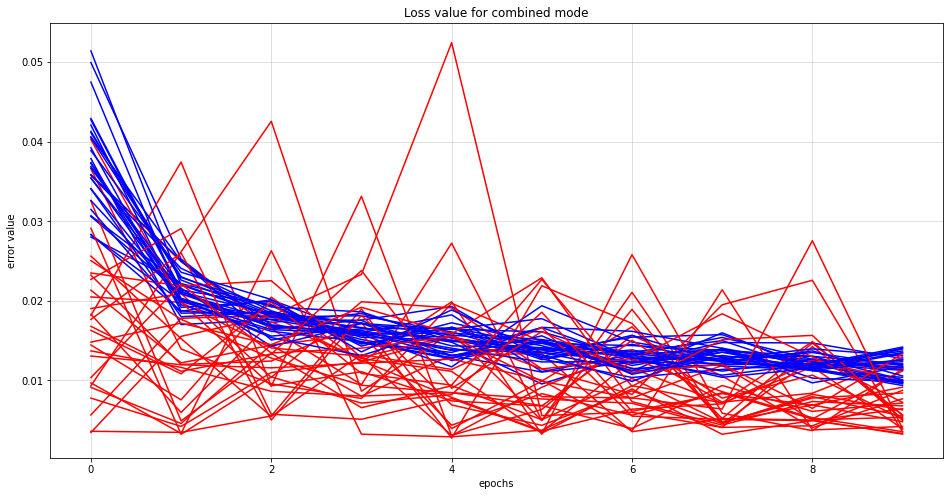

In [62]:
for i in range(len(model_mode)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(model_mode[i]) + ' mode')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error value')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for j in range(30):
        
        if (model_mode == 'single'):
            x_train, y_train, x_test, y_test, scaler = SplitData(single_data, train_portion, timestep)
        else:
            x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModelFineTune(x_train, y_train, 10, 64)
        end_time = time.time()
        training_time = end_time - start_time

        predictions = sentimentModel.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        compare_finetune_test.append([model_mode[i], j, mae, mse, rmse, mape, training_time])

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        compare_finetune_history.append([model_mode[i], j, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])

        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('compare_finetune_data/'+ str(model_mode[i]) +'_mode_diagnostic.png', facecolor=(1, 1, 1))

In [63]:
compare_test_finetuning = pd.DataFrame(compare_finetune_test, columns=['mode', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
compare_test_finetuning

,mode,#try,MAE,MSE,RMSE,MAPE,train_time
0,single,0,17.421750,465.341829,21.571783,6.111127,60.002204
1,single,1,16.889501,440.789129,20.994979,5.908653,64.513783
2,single,2,15.421340,368.903917,19.206872,5.381450,57.081860
3,single,3,14.892627,353.413078,18.799284,5.158047,64.717089
4,single,4,16.713082,436.169959,20.884682,5.851946,56.688825
...,...,...,...,...,...,...,...
95,combined,25,15.330698,368.482959,19.195910,5.290694,46.586666
96,combined,26,17.272904,455.570621,21.344100,6.065920,48.422731
97,combined,27,14.570543,328.528910,18.125366,5.104423,52.060079
98,combined,28,15.100173,360.957083,18.998871,5.204421,50.862236


In [64]:
compare_test_finetuning.to_csv('compare_finetune_data/finetuning_test_data.csv', index=False)

In [80]:
compare_test_finetuning = pd.read_csv('compare_finetune_data/finetuning_test_data.csv')
compare_test_finetuning

,mode,#try,MAE,MSE,RMSE,MAPE,train_time
0,single,0,14.820254,341.718029,18.485617,5.174782,49.858555
1,single,1,16.171950,410.927426,20.271345,5.657617,48.059193
2,single,2,17.007271,444.769529,21.089560,5.975452,47.437150
3,single,3,16.812838,434.197669,20.837410,5.721137,50.537003
4,single,4,21.445013,659.644824,25.683552,7.537597,47.410979
5,single,5,15.745659,383.644062,19.586834,5.512471,48.886993
6,single,6,17.201106,450.420381,21.223110,6.056320,49.001836
7,single,7,25.918033,917.644034,30.292640,9.103364,49.629222
8,single,8,14.785627,342.802699,18.514932,5.165778,46.762804
9,single,9,15.246064,360.936292,18.998323,5.361667,47.703757


In [147]:
xyz = compare_test_finetuning[30:60]
xyz.describe()

,#try,MAE,MSE,RMSE,MAPE,train_time
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,16.076312,403.804128,19.994858,5.606447,47.599678
std,8.803408,1.882589,91.513769,2.036681,0.682744,2.030250
min,0.000000,14.341799,321.584297,17.932772,4.958982,44.276962
25%,7.250000,15.053930,356.114765,18.870859,5.206909,45.926579
50%,14.500000,15.552683,377.368723,19.425973,5.441439,47.256189
75%,21.750000,16.444350,424.642237,20.606814,5.766020,48.986405
max,29.000000,23.905364,795.169727,28.198754,8.405309,52.060079


In [81]:
compare_test_finetune_rmse = compare_test_finetuning.pivot(index='#try', columns='mode', values='RMSE')
compare_test_finetune_rmse

mode,combined,single
#try,,
0,20.540938,18.485617
1,19.529879,20.271345
2,28.198754,21.089560
3,19.289340,20.837410
4,18.103702,25.683552
5,19.747095,19.586834
6,21.273359,21.223110
7,20.192862,30.292640
8,18.091853,18.514932


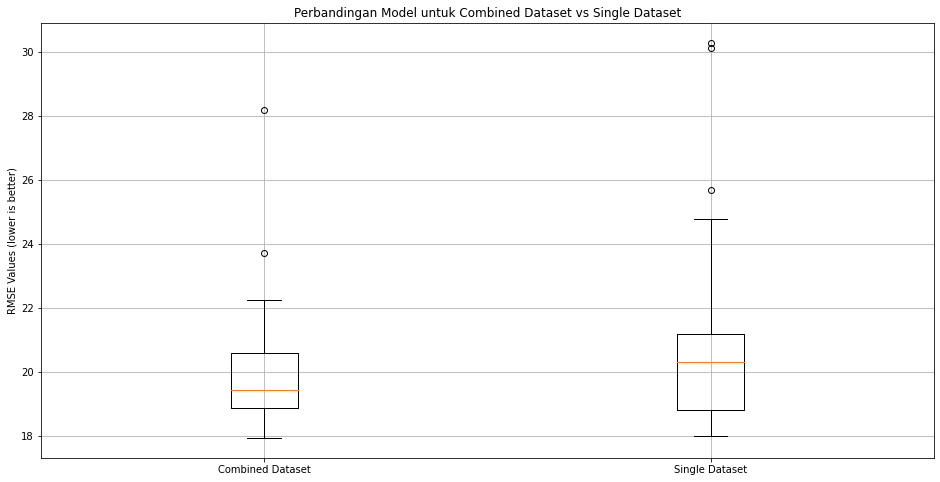

In [148]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(compare_test_finetune_rmse)
ax.set_xticklabels(['Combined Dataset', 'Single Dataset'])
ax.set_title("Perbandingan Model untuk Combined Dataset vs Single Dataset")
ax.set_ylabel('RMSE Values (lower is better)')
ax.grid()
plt.savefig('compare_finetune_data/comparison_boxplot.png', facecolor=(1, 1, 1))

In [67]:
compare_history_finetuning = pd.DataFrame(compare_finetune_history, columns=['mode', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
compare_history_finetuning

,mode,#try,loss,val_loss,mae,val_mae,train_time
0,single,0,"[0.03593260049819946, 0.022195210680365562, 0....","[0.006584043148905039, 0.010901507921516895, 0...","[0.14049720764160156, 0.11857044696807861, 0.1...","[0.06612832099199295, 0.09017975628376007, 0.0...",60.002204
1,single,1,"[0.03802042827010155, 0.01595456525683403, 0.0...","[0.022324327379465103, 0.016727536916732788, 0...","[0.15788622200489044, 0.09906866401433945, 0.1...","[0.13915270566940308, 0.11755108833312988, 0.1...",64.513783
2,single,2,"[0.04008970037102699, 0.023075757548213005, 0....","[0.028068022802472115, 0.012959010899066925, 0...","[0.1542641669511795, 0.1205623671412468, 0.105...","[0.15829496085643768, 0.09915895760059357, 0.1...",57.081860
3,single,3,"[0.030870936810970306, 0.0209377259016037, 0.0...","[0.005585327744483948, 0.005597280338406563, 0...","[0.13837070763111115, 0.1159186139702797, 0.10...","[0.05945233628153801, 0.0597514882683754, 0.08...",64.717089
4,single,4,"[0.03769470378756523, 0.023332504555583, 0.015...","[0.022730333730578423, 0.02001935988664627, 0....","[0.1506541222333908, 0.1261022984981537, 0.101...","[0.14053818583488464, 0.13002541661262512, 0.1...",56.688825
...,...,...,...,...,...,...,...
95,combined,25,"[0.040491800755262375, 0.023030690848827362, 0...","[0.01629342883825302, 0.010833126492798328, 0....","[0.15927352011203766, 0.12477823346853256, 0.1...","[0.11483855545520782, 0.08825109153985977, 0.1...",46.586666
96,combined,26,"[0.035801514983177185, 0.02409232221543789, 0....","[0.014812596142292023, 0.017202598974108696, 0...","[0.15602535009384155, 0.11817118525505066, 0.1...","[0.10936713963747025, 0.11933087557554245, 0.1...",48.422731
97,combined,27,"[0.032611098140478134, 0.0203300379216671, 0.0...","[0.016799576580524445, 0.011150062084197998, 0...","[0.14759811758995056, 0.11548256874084473, 0.1...","[0.11829611659049988, 0.0920068770647049, 0.10...",52.060079
98,combined,28,"[0.0340963639318943, 0.019941648468375206, 0.0...","[0.010357489809393883, 0.022105665877461433, 0...","[0.14113205671310425, 0.11296363174915314, 0.1...","[0.08762842416763306, 0.13844376802444458, 0.1...",50.862236


In [68]:
compare_history_finetuning.to_csv('compare_finetune_data/finetuning_history_data.csv', index=False)

In [85]:
compare_history_finetuning = pd.read_csv('compare_finetune_data/finetuning_history_data.csv')
compare_history_finetuning

,mode,#try,loss,val_loss,mae,val_mae,train_time
0,single,0,"[0.05601806938648224, 0.022103777155280113, 0....","[0.021422259509563446, 0.008851700462400913, 0...","[0.17613092064857483, 0.12101942300796509, 0.1...","[0.13713037967681885, 0.0797925665974617, 0.06...",49.858555
1,single,1,"[0.0388423353433609, 0.018731815740466118, 0.0...","[0.009617018513381481, 0.021097742021083832, 0...","[0.1578907072544098, 0.11037509888410568, 0.09...","[0.08285004645586014, 0.1335417479276657, 0.05...",48.059193
2,single,2,"[0.05321687087416649, 0.020993856713175774, 0....","[0.026132239028811455, 0.01120217889547348, 0....","[0.17694224417209625, 0.11688126623630524, 0.1...","[0.15215973556041718, 0.08977628499269485, 0.1...",47.437150
3,single,3,"[0.036219917237758636, 0.017830433323979378, 0...","[0.016491664573550224, 0.003475470934063196, 0...","[0.1484401971101761, 0.1093699187040329, 0.106...","[0.11600559204816818, 0.049627192318439484, 0....",50.537003
4,single,4,"[0.03806798532605171, 0.02247711457312107, 0.0...","[0.029992600902915, 0.004261472728103399, 0.01...","[0.15761281549930573, 0.11525516957044601, 0.1...","[0.16492913663387299, 0.05027025192975998, 0.0...",47.410979
5,single,5,"[0.033690910786390305, 0.0196160189807415, 0.0...","[0.013304530642926693, 0.025482123717665672, 0...","[0.14478635787963867, 0.11233077198266983, 0.1...","[0.10111093521118164, 0.1486608386039734, 0.07...",48.886993
6,single,6,"[0.0310260821133852, 0.01937936618924141, 0.01...","[0.020605389028787613, 0.014538179151713848, 0...","[0.13661596179008484, 0.1111125573515892, 0.10...","[0.13445661962032318, 0.10946057736873627, 0.0...",49.001836
7,single,7,"[0.05090418830513954, 0.02041599340736866, 0.0...","[0.03897199034690857, 0.007735991384834051, 0....","[0.17719925940036774, 0.11366231739521027, 0.1...","[0.18944810330867767, 0.07248099148273468, 0.0...",49.629222
8,single,8,"[0.03304361179471016, 0.02034251019358635, 0.0...","[0.027605656534433365, 0.019420195370912552, 0...","[0.1452607363462448, 0.1164916530251503, 0.113...","[0.15685950219631195, 0.12687812745571136, 0.1...",46.762804
9,single,9,"[0.037986304610967636, 0.02176148258149624, 0....","[0.022338243201375008, 0.020194848999381065, 0...","[0.15019072592258453, 0.11609683185815811, 0.1...","[0.13997432589530945, 0.13130034506320953, 0.1...",47.703757
